<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
Exploratory Data Analysis - raw data only</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

This report provides an overview of the GLTD dataset. No modelling is performed, only raw data is displayed.

The Society of Actuaries Group Disability Insurance Experience Committee has written a report which provides background on the use case and the data. It can be found at URL "https://www.soa.org/4a7e84/globalassets/assets/files/resources/experience-studies/2019/2019-gltd-study-report.pdf".

All inputs (except for a few numerical variables) are treated as categorical variables, and two graphs are shown for each variable. In each graph, the total dataset is grouped according to the unique levels of the respective variable. The x-values always correspond to these discrete levels. The y-values of the two graphs are then respectively

1. The relative exposures of each level. 
2. The empirical probabilities of recovery of each level.  

Since fractional exposures are removed (see discussion in "data_preparation.ipynb") relative exposure of a level is the number of observations in the group defined by the level divided by the total number of all observations. Accordingly, all relative exposures of the levels of a variable add up to 100%.

Likewise, the empirical probability of recovery is the number of observed recoveries in a group divided by the total number of observations in this group. Since each observation is a realization of a Bernoulli variable and assumed to be independent conditional on its inputs, and grouping amounts to just adding-up those realizations, the grouped data can be modelled as Binomial variables. This makes it possible to calculate and display exact Clopper-Pearson confidence intervals for the probabilities. These are shown in the graphs as lines above and below the averages. Due to the large size of the dataset, in many cases these confidence intervals will be so tight as not to be visible in the graphs.

The grouping mechanism does not work for those numeric variables, where each level just consists of a single observation. Purely for simplicity of code, these numeric variables will be shown anyway in the first section. But in latter sections these variables will be binned into intervals, treated as categorical and displayed in the same way as all other variables.   

## Terminology
Summing up Actual_Recoveries per group respectively level and dividing by the total size of the group, is just the calculation of the empirical conditional probability of recovery, conditional on the level. Plots of conditional probabilities like this are called M-plots in [Molnar]. These plots are similar to, but slightly different from PDP plots, in that they use the actual data distribution instead of independent realizations. This has the benefit that these plots do not suffer from any "impossible data" issues and can be generated without a model, i.e. for the raw data.

## Some observations

The data set shows typical traits of raw actuarial data:
* Large number of inputs
* Mix of numerical and categorical inputs 
* Many of the categorical inputs have large cardinality
* Categories have very imbalanced exposures
* The impact of the inputs on the target, i.e. the recovery rate varies a lot between inputs, but also within categories.

State-of-the-art modelling would probably require diligent feature selection and feature engineering. Since this use case focuses on demonstration of explainability methods, we have shunned this considerable effort and mainly proceed with the data as-is.

# Initialisation

Line 20 below contains the path to the data variable, which is created by the prior notebooks "data_initialisation" and "data_preparation". It has to be modified according to your local set up. 

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt

from scipy.stats import beta

from IPython.display import display, Pretty
import matplotlib.pyplot as plt
# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# input data
#-------------------------------
datadir = "./"
#-------------------------------

fn_in = "gltd09_13work.feather"
gltd = pd.read_feather(datadir + fn_in)  
nm_all = pd.Series(gltd.columns)

# Utility functions

The first function calculates the confidence limits.

In [2]:
def confi(n, k):
    """ Clopper-Person Confidence Interval for the binomial distribution
    
        see https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
    """

    if isinstance(n, pd.core.frame.DataFrame):
        n = n.to_numpy()
        k = k.to_numpy()

    alpha = 0.1
    p = k / n
    lo = np.zeros_like(p)
    hi = np.zeros_like(p)

    lo = beta.ppf(alpha/2, k, n - k + 1)
    hi = beta.ppf(1 - alpha/2, k + 1, n - k)

    hi[k == 0] = 1 - (alpha / 2) ** (1 / n[k==0])
    lo[k == 0] = 0
    lo[k == n] = (alpha / 2) ** (1 / n[k==n])
    hi[k==n] = 1

    return np.column_stack((p, lo, hi))

The next function sums up the groups and applies the confidence intervals.

In [3]:
def rawrates(factor_list, data):
    grouped = data[factor_list 
                   + ["Actual_Recoveries"]].groupby(factor_list, 
                                                    as_index=False, 
                                                    observed=False)
    nk = grouped.agg(n = ("Actual_Recoveries", "count"), 
                     k = ("Actual_Recoveries", "sum"))
    tmp = pd.DataFrame(confi(nk[["n"]], nk[["k"]]), columns=["p", "lo", "hi"])
    return(pd.concat([nk, tmp], axis=1))

# Exposures and recovery rates

## Overall recovery rate

The overall rate is the sum of all recoveries divided by the number of all observations. 

In [4]:
display(Pretty(f"Number of observations: {gltd.shape[0]} \n\
Number of recoveries: {gltd["Actual_Recoveries"].sum()}\n\
Average recovery rate: {round(100 * gltd["Actual_Recoveries"].sum() / gltd.shape[0],2)}%"))

Number of observations: 6388739 
Number of recoveries: 90827
Average recovery rate: 1.42%

This demonstrates another basic challenge with the data: Monthly recovery is a rare event. To ensure a sufficient number of observations in the minority class, the total number of observations needs to be accordingly large. While the available amount of data is certainly large enough, runtime will be a challenge for many types of analysis and modelling.     

## Marginal recovery rates

In [5]:
# classification of inputs
col_cat = {'Elimination_Period', 'Diagnosis_Category', 
            'OwnOccToAnyTransition', 'Gender','Mental_and_Nervous_Period', 
           "M_N_Limit_Transition", 'Industry', 'Taxability_of_Benefits', 
           'Integration_with_STD','Residence_State', 'COLA_Indicator', 
           'Benefit_Max_Limit_Proxy', 'Original_Social_Security_Award_Status',
           'Updated_Social_Security_Award_Status'}

col_num = {'Duration_Month', 'Age_at_Disability', 'Attained_Age', 
           'Gross_Indexed_Benefit_Amount', 'Indexed_Monthly_Salary', 
           'Case_Size','Replacement_Ratio', 'Month_of_Study'}

nm_fac = list(col_cat.union(col_num) )

Note below the different y-scales when comparing the between different inputs!
These graphs with the raw probabilities provide a first impression of variable importance. A variable is important when the y-values of different levels are very different. Examples are "Attained_Age", "Original_Social_Security_Award_Status", "Diagnosis_Category" and "Duration_Month". In contrast, "Gender" does not seem to be that important.

In [6]:
# accumulate all marginal data
marge_all = {fac: rawrates([fac], gltd) for fac in nm_fac}
totex = gltd.shape[0]

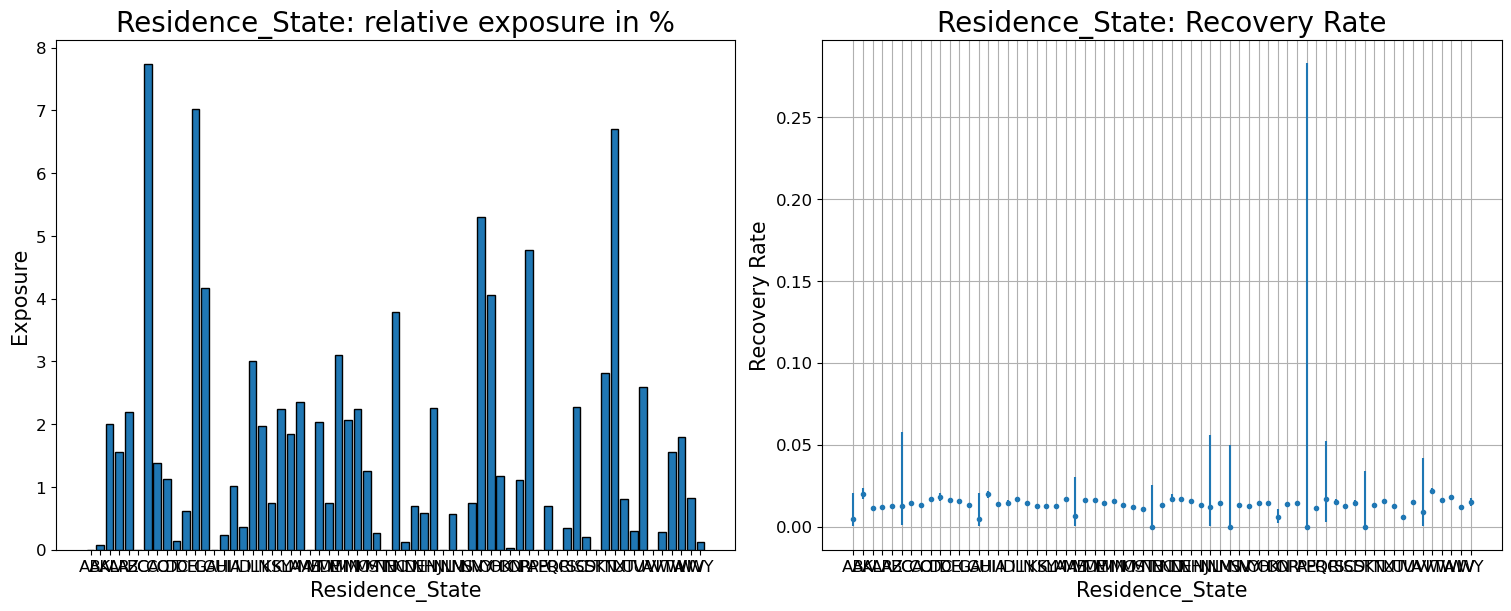

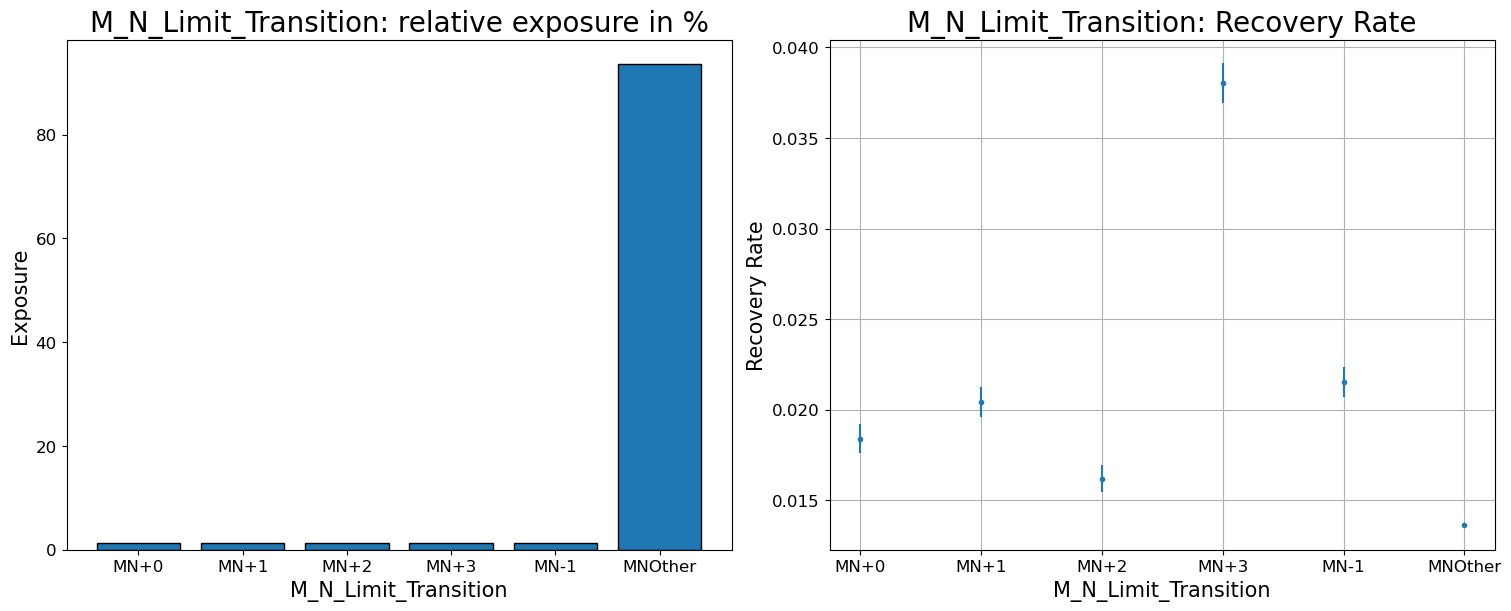

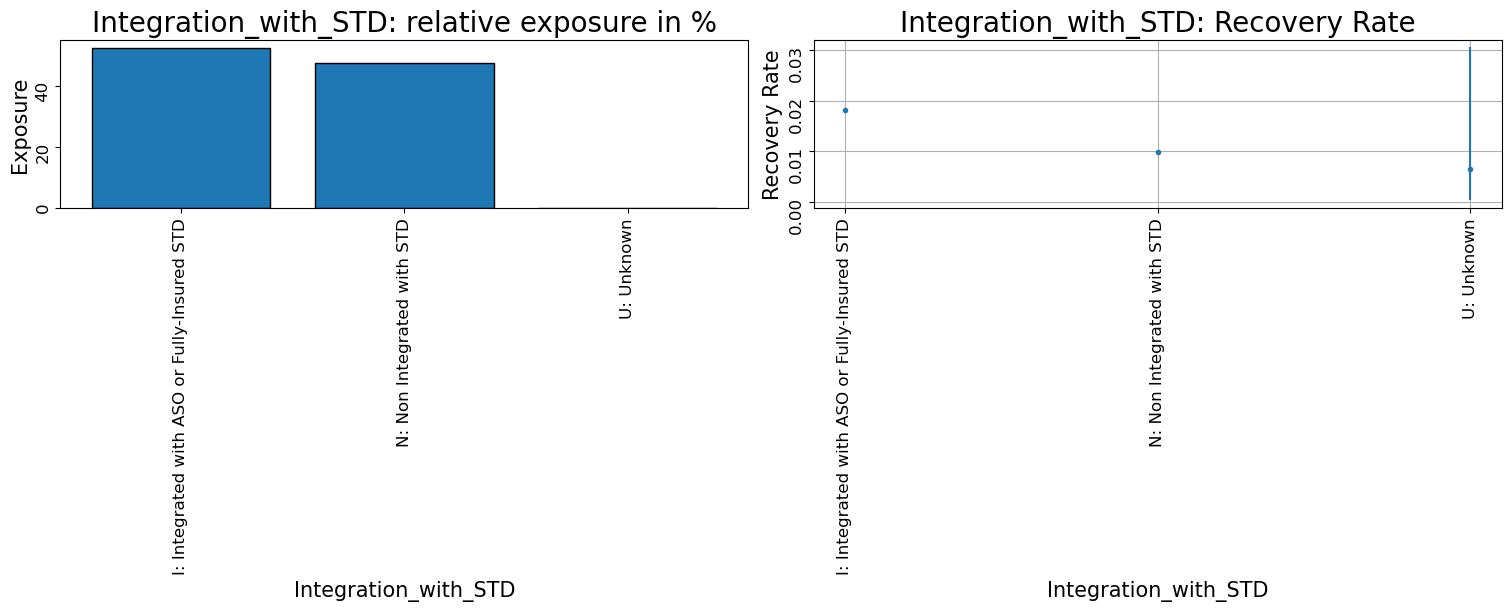

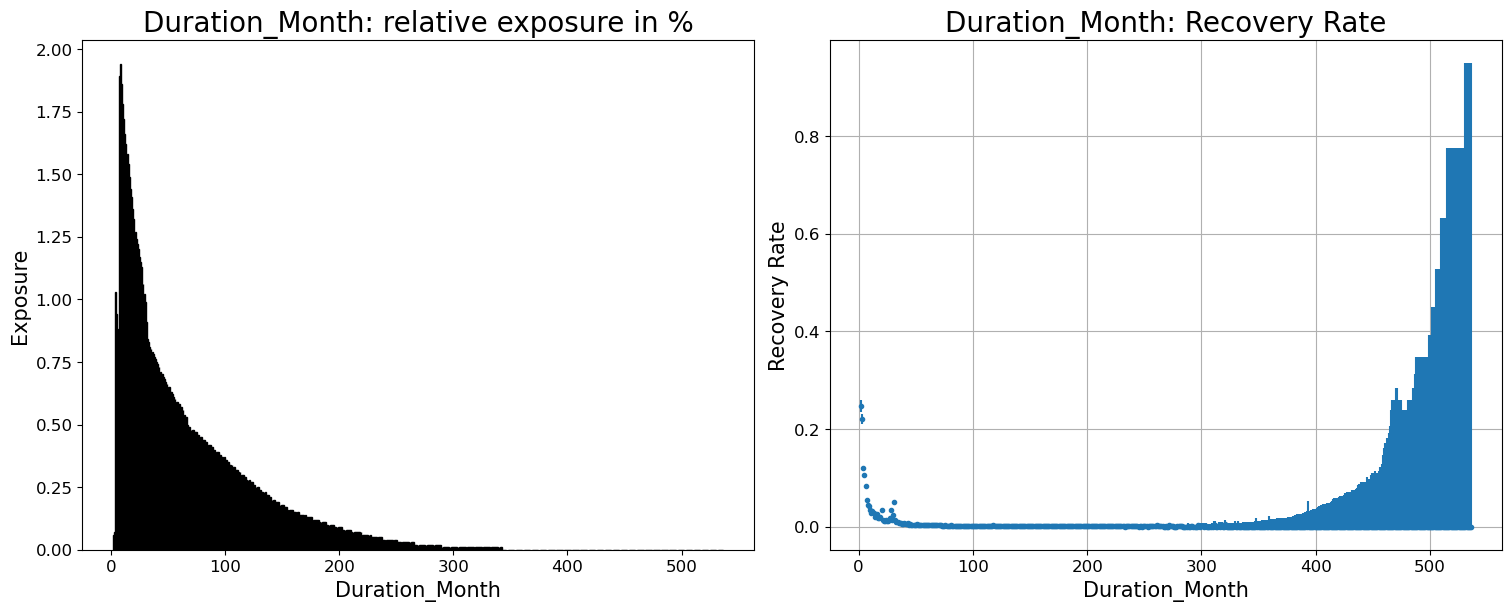

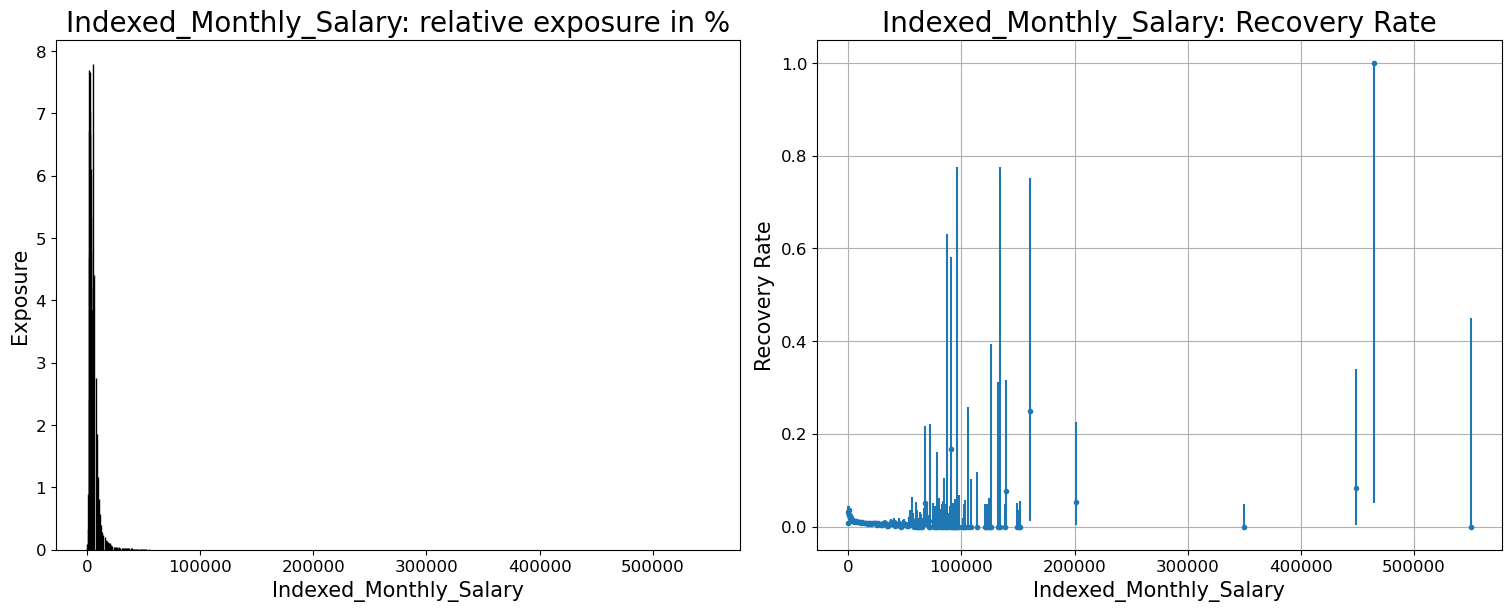

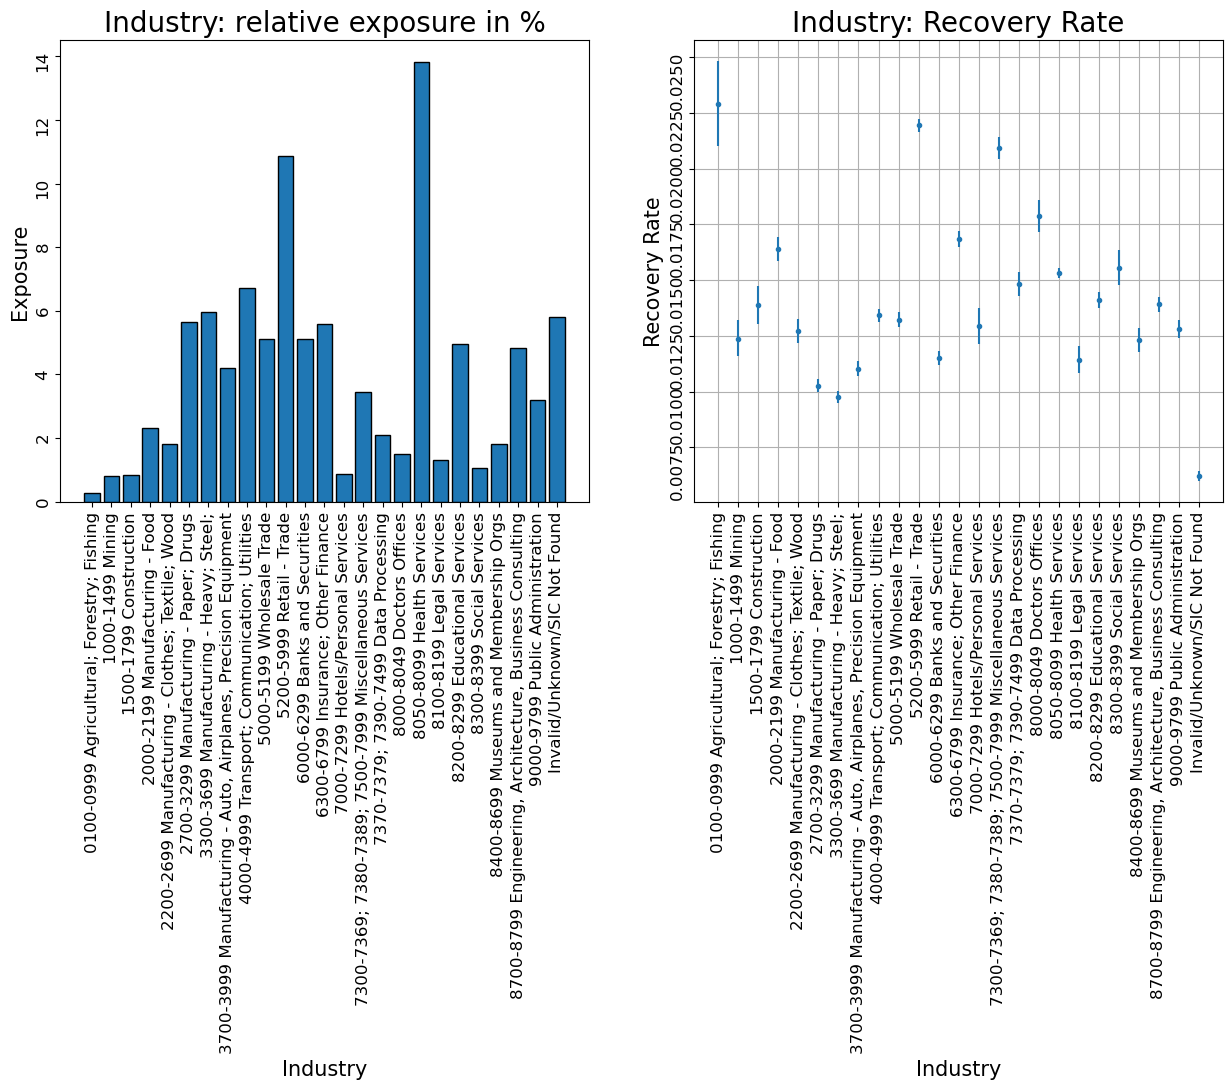

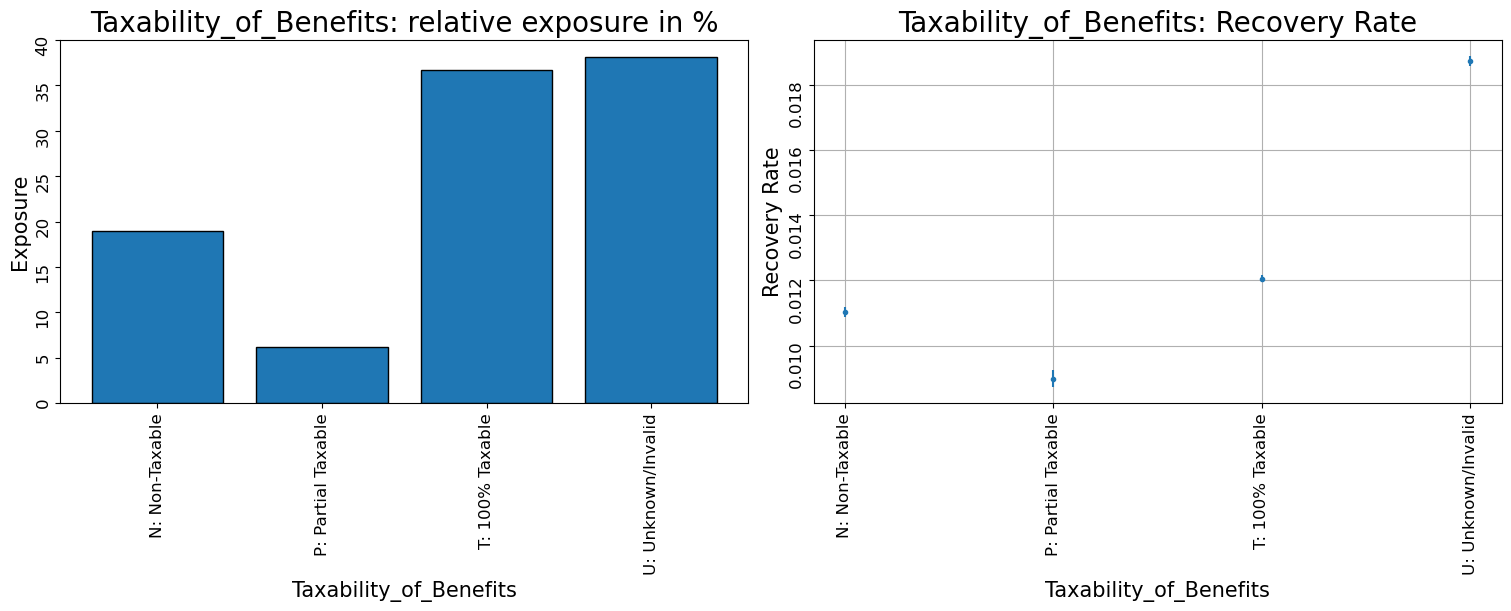

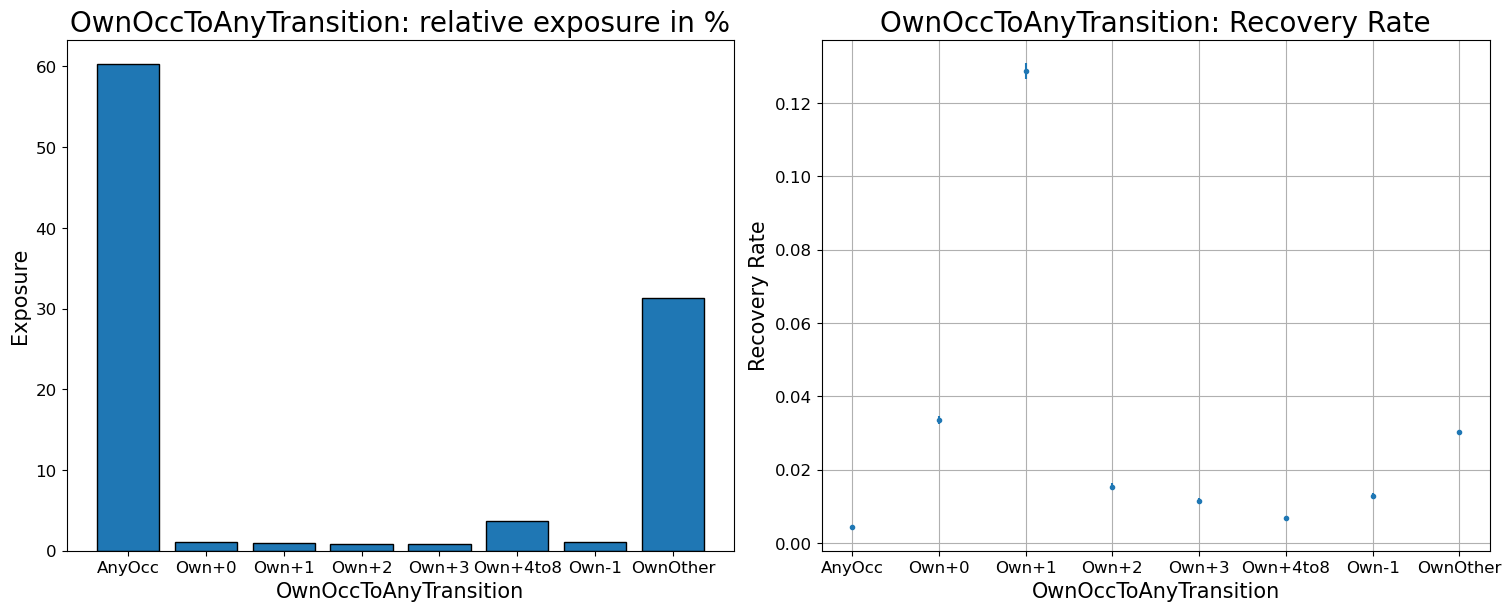

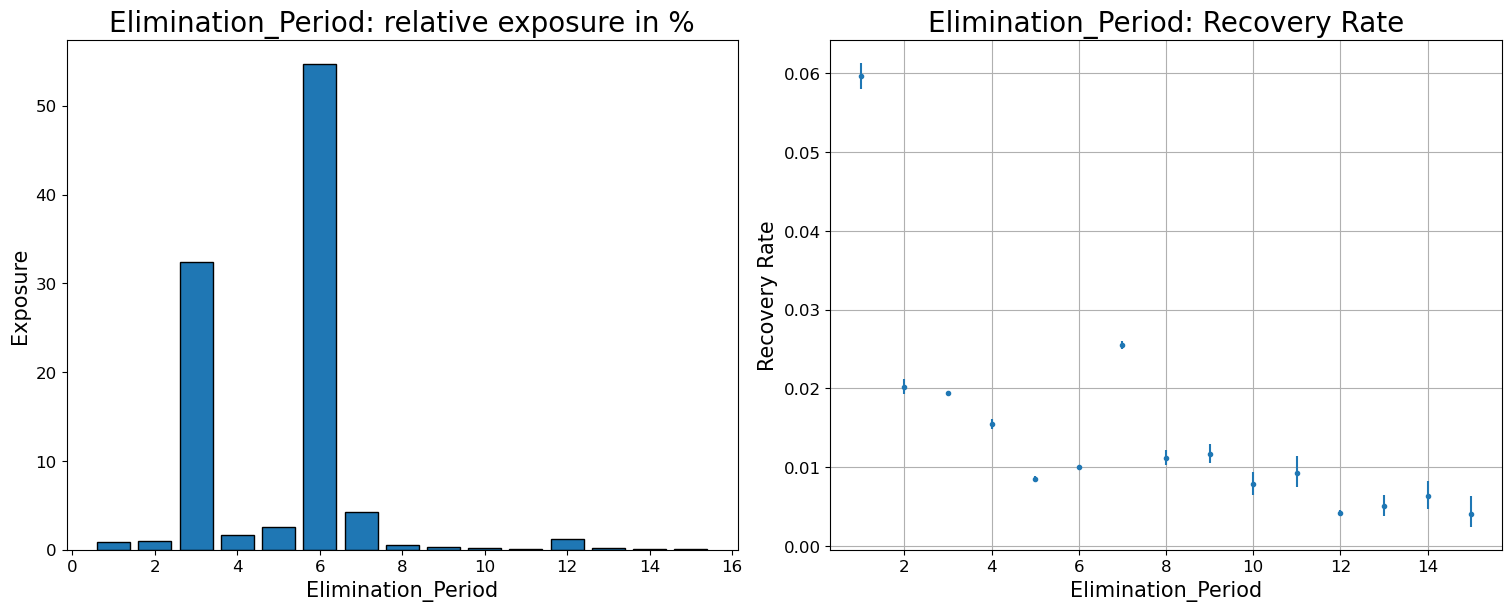

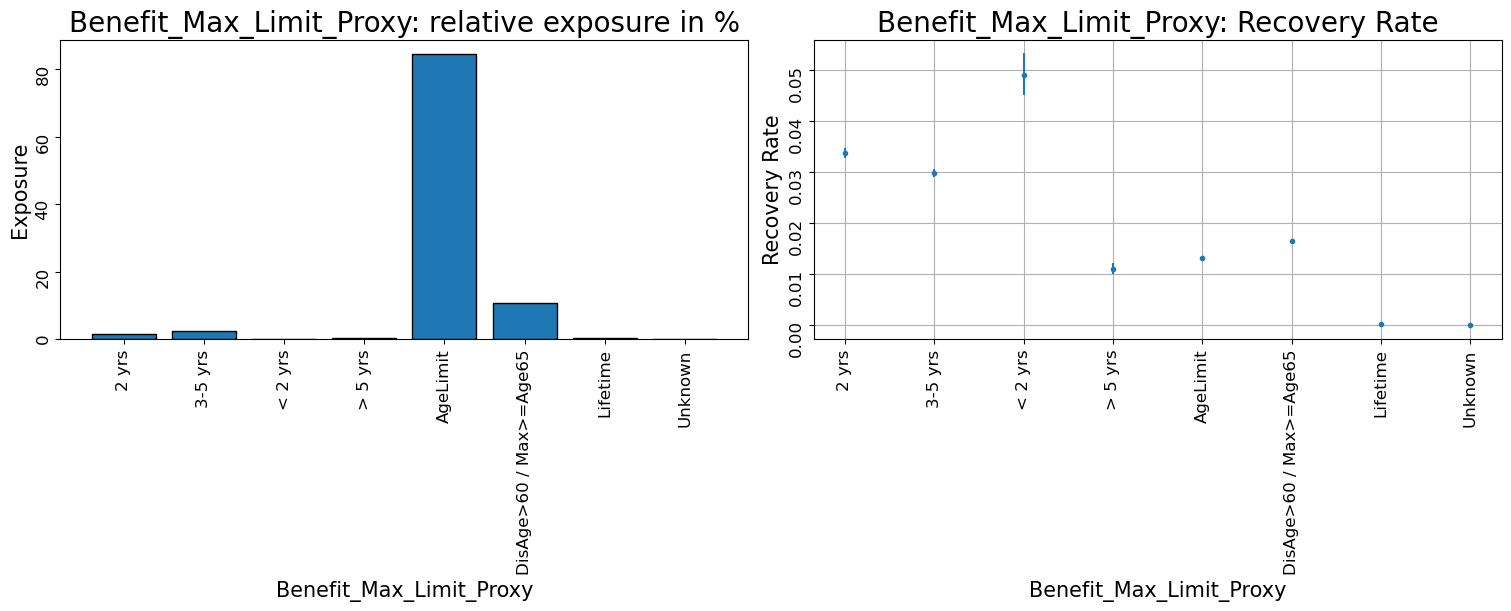

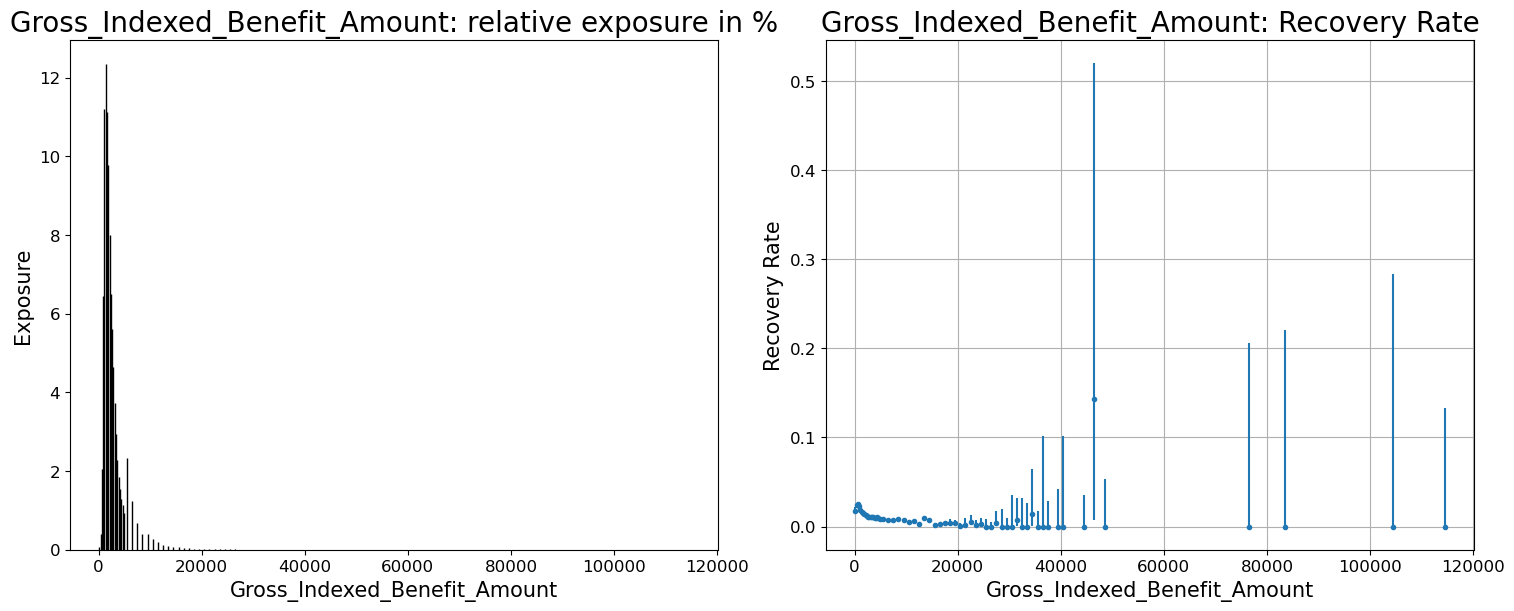

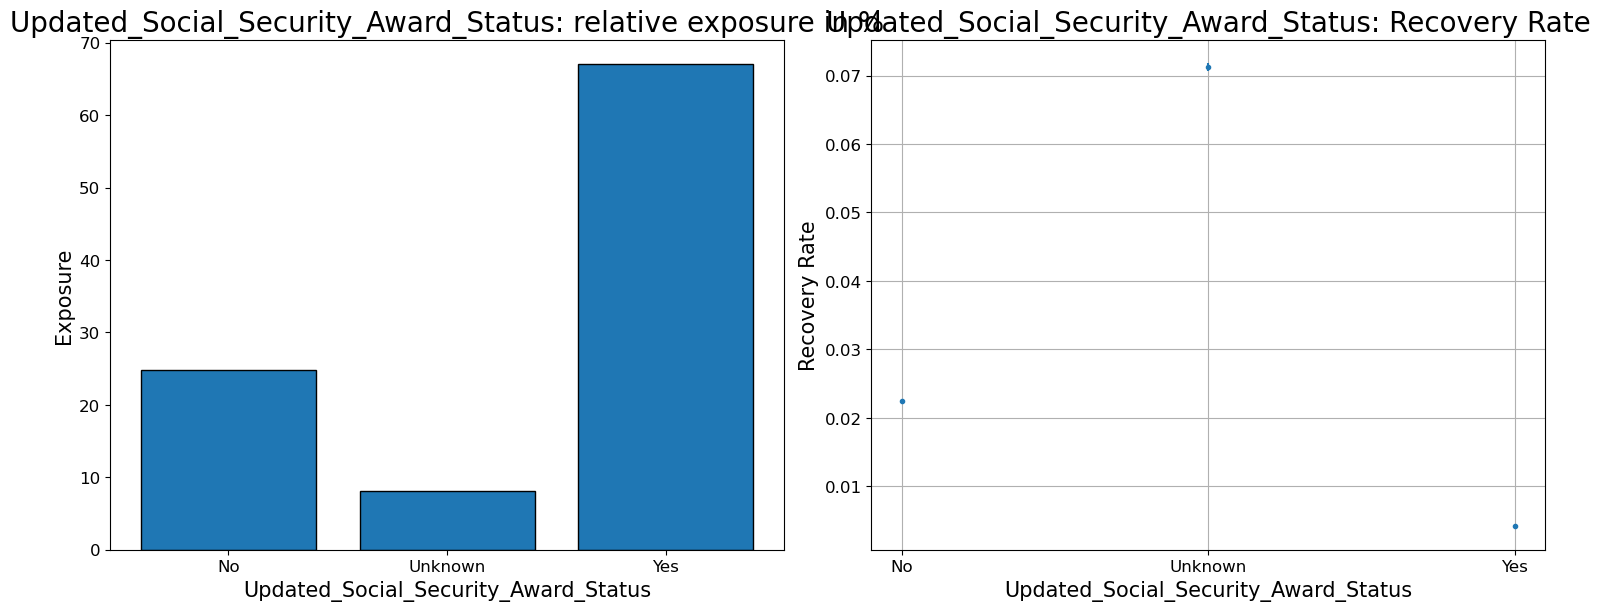

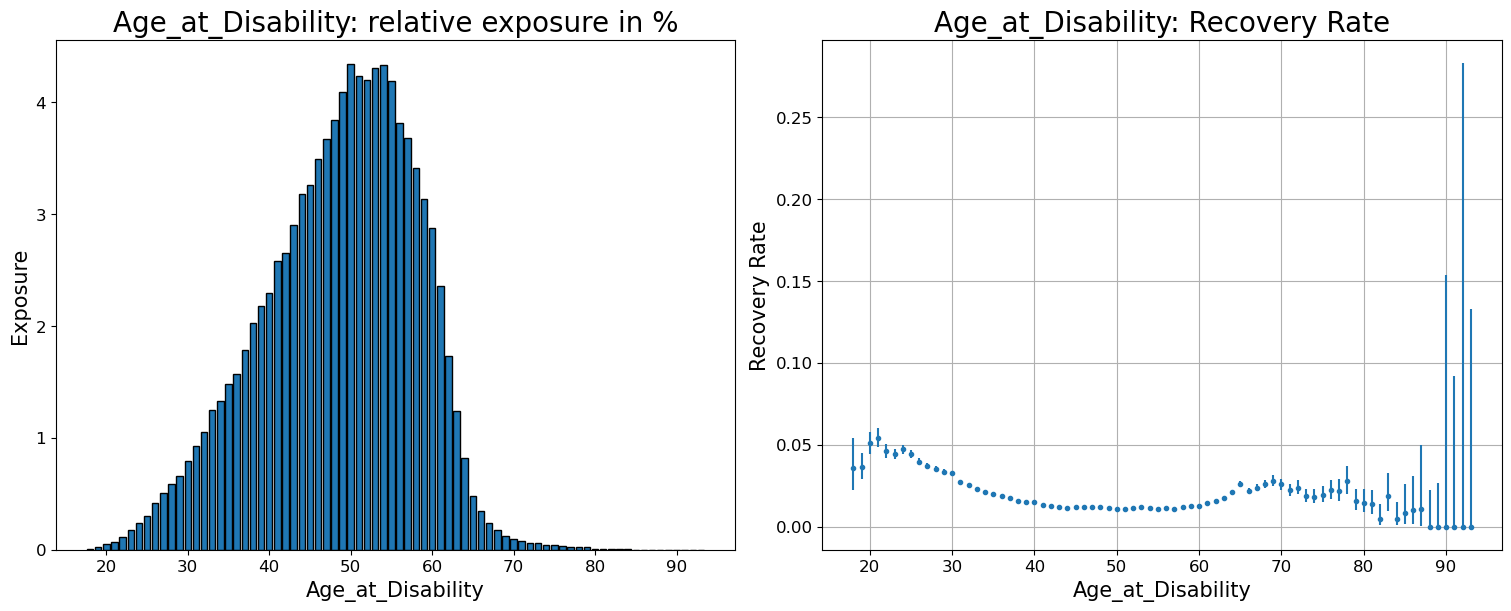

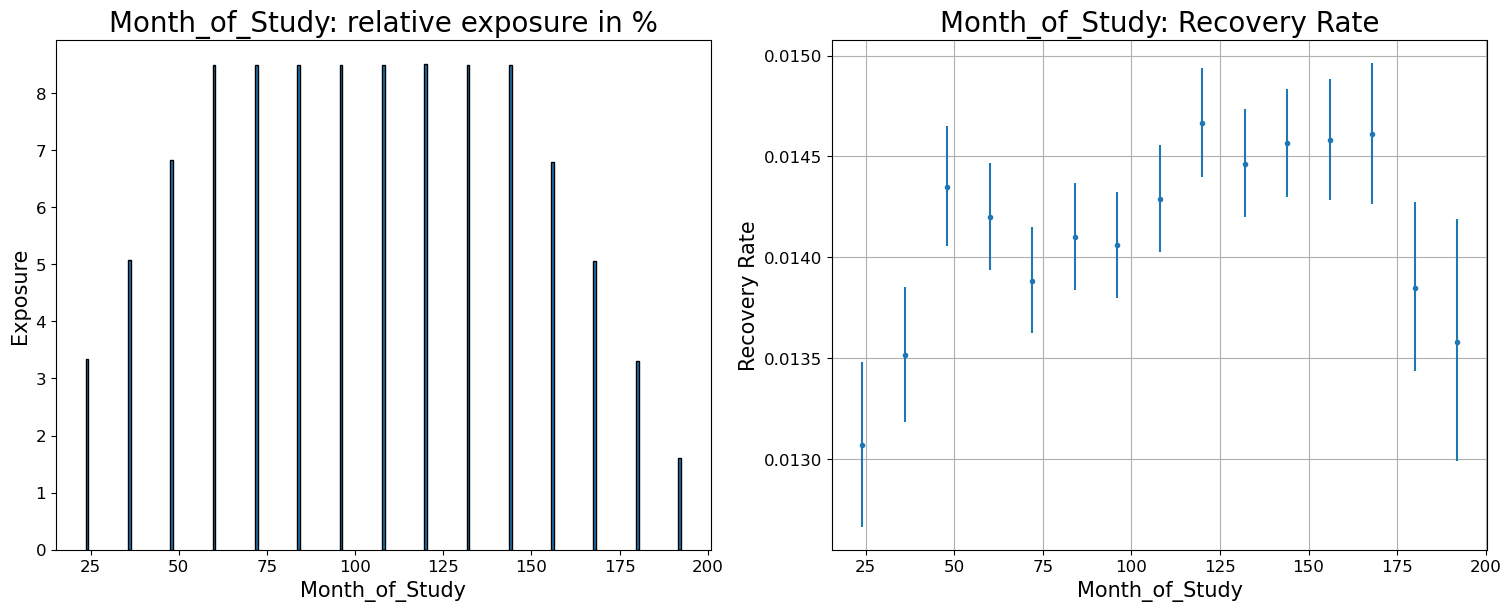

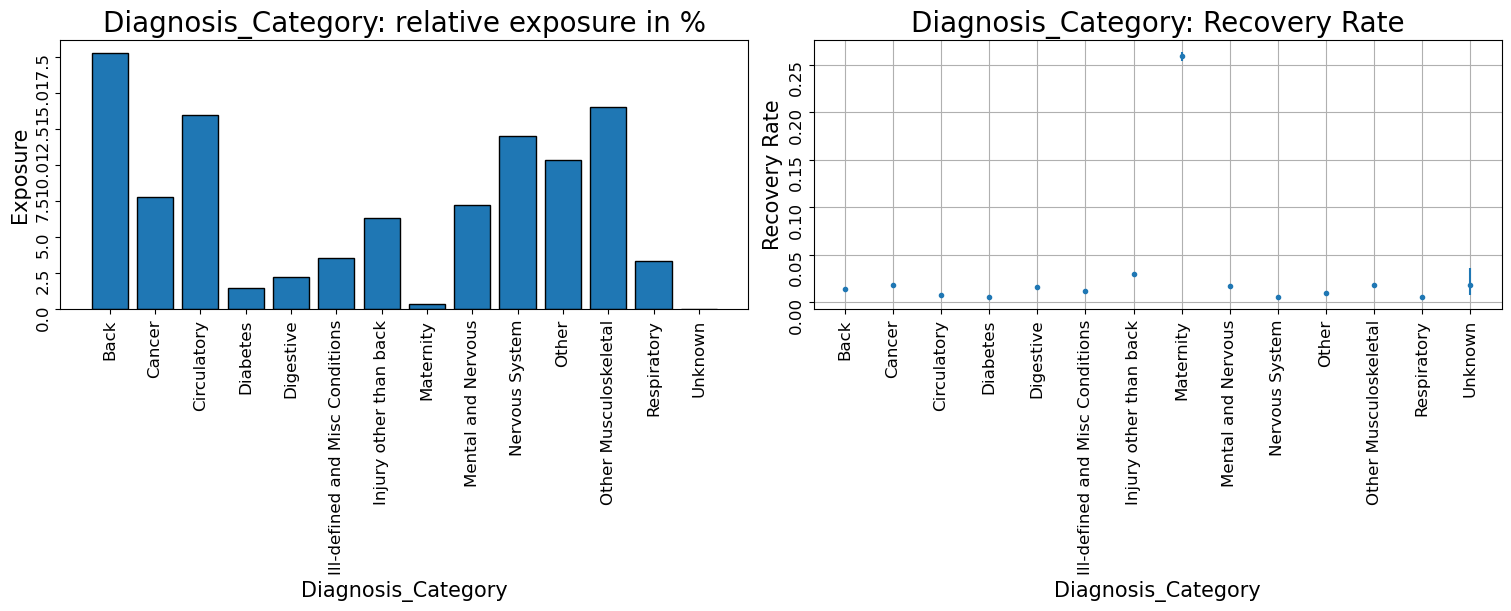

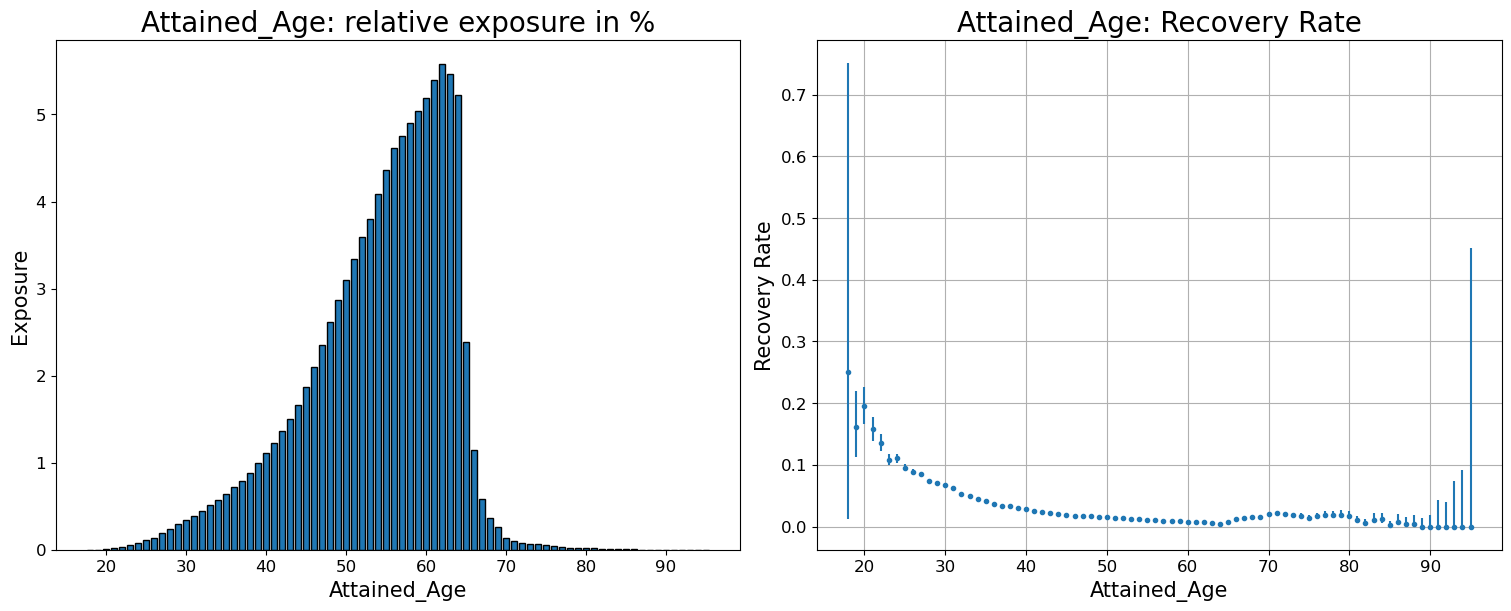

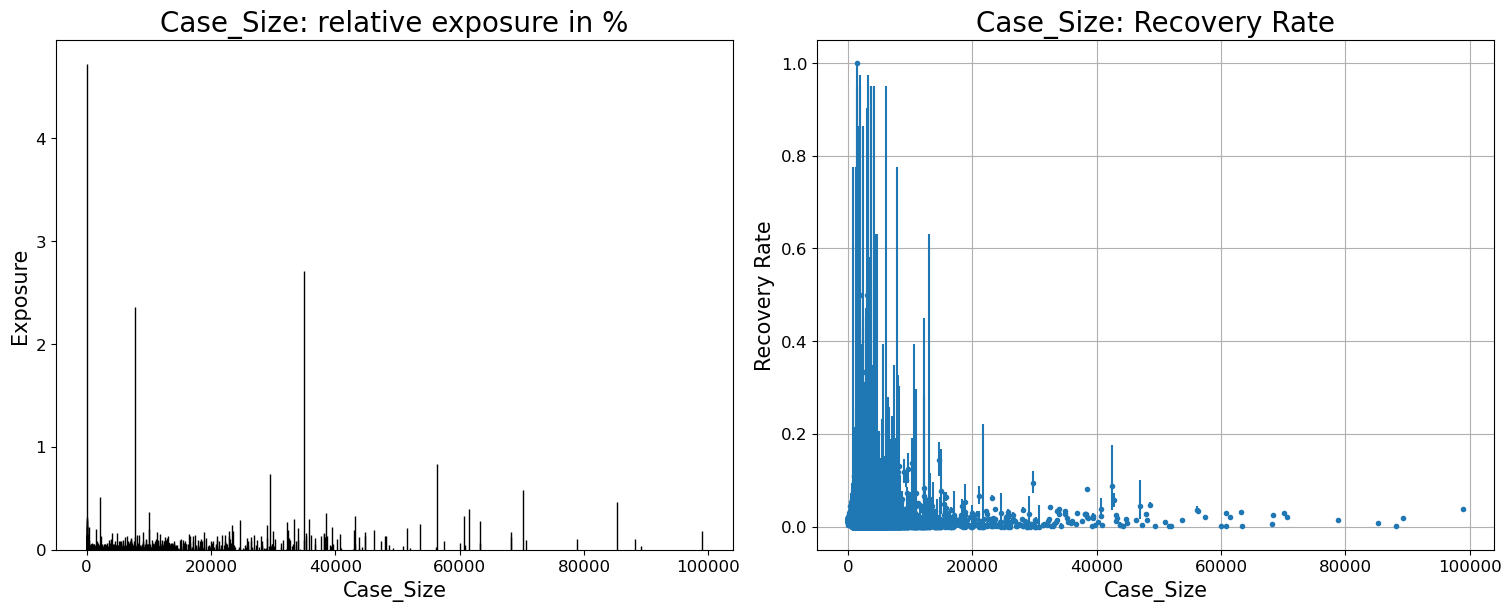

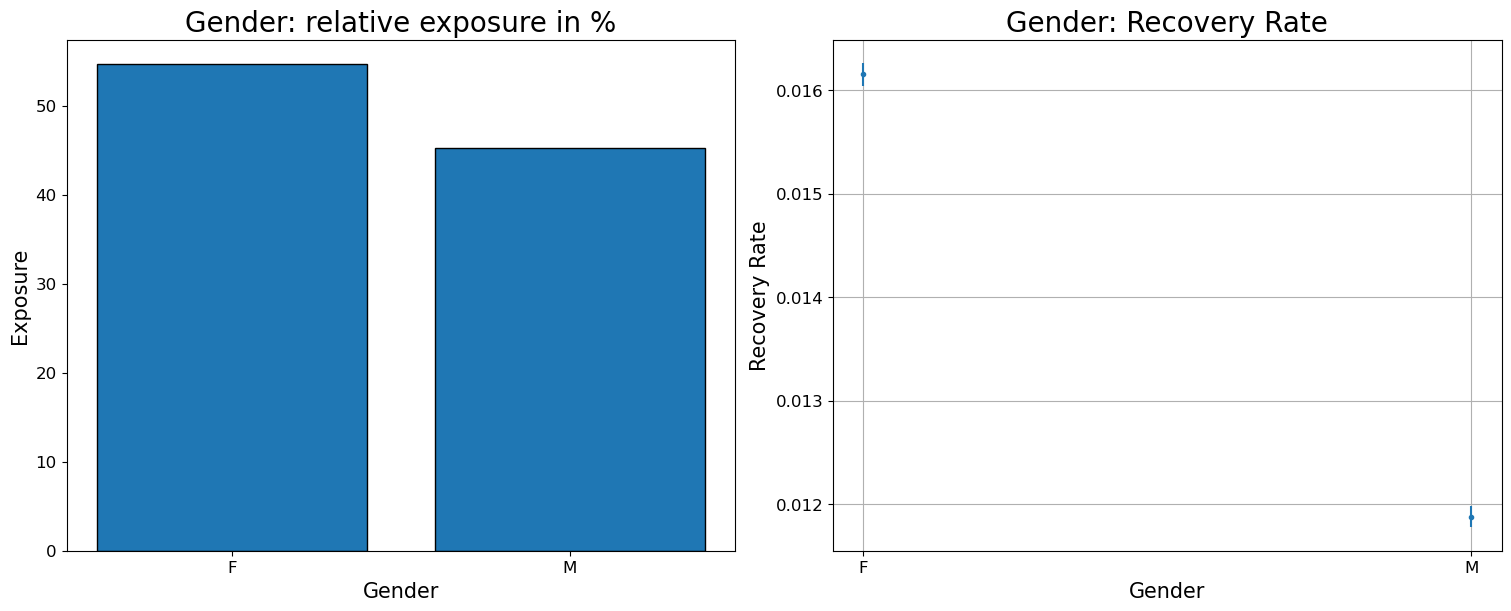

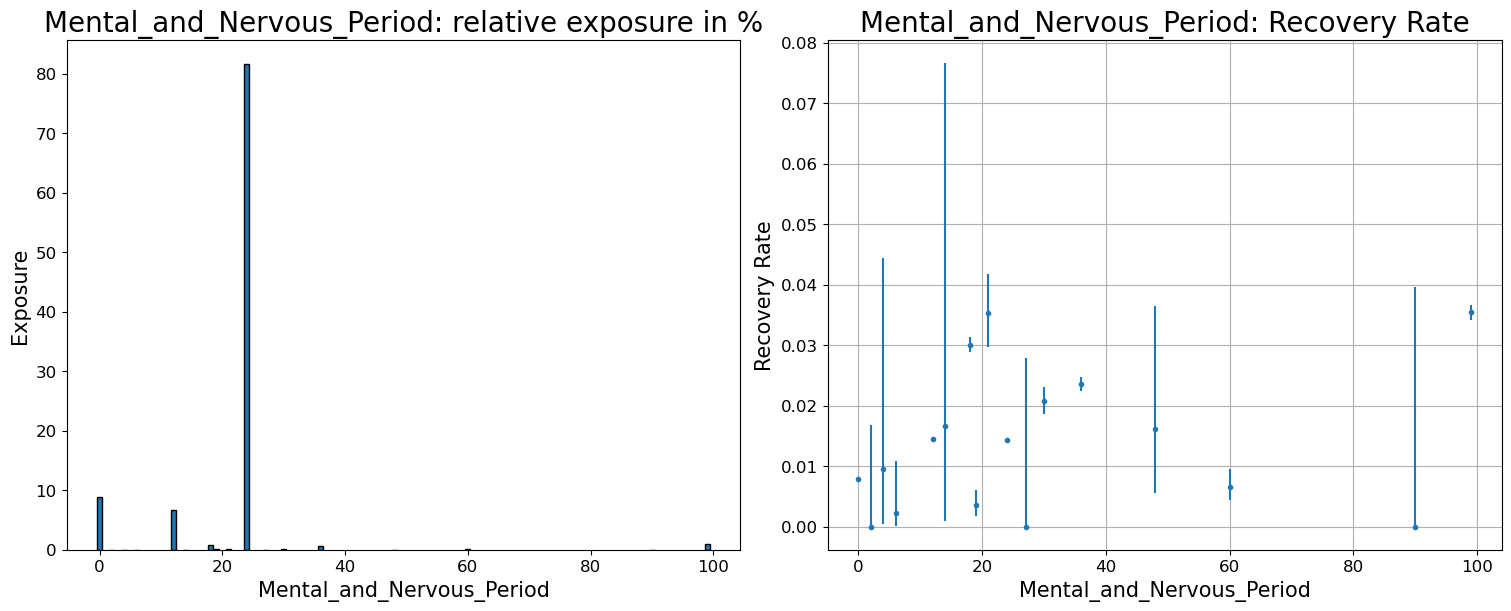

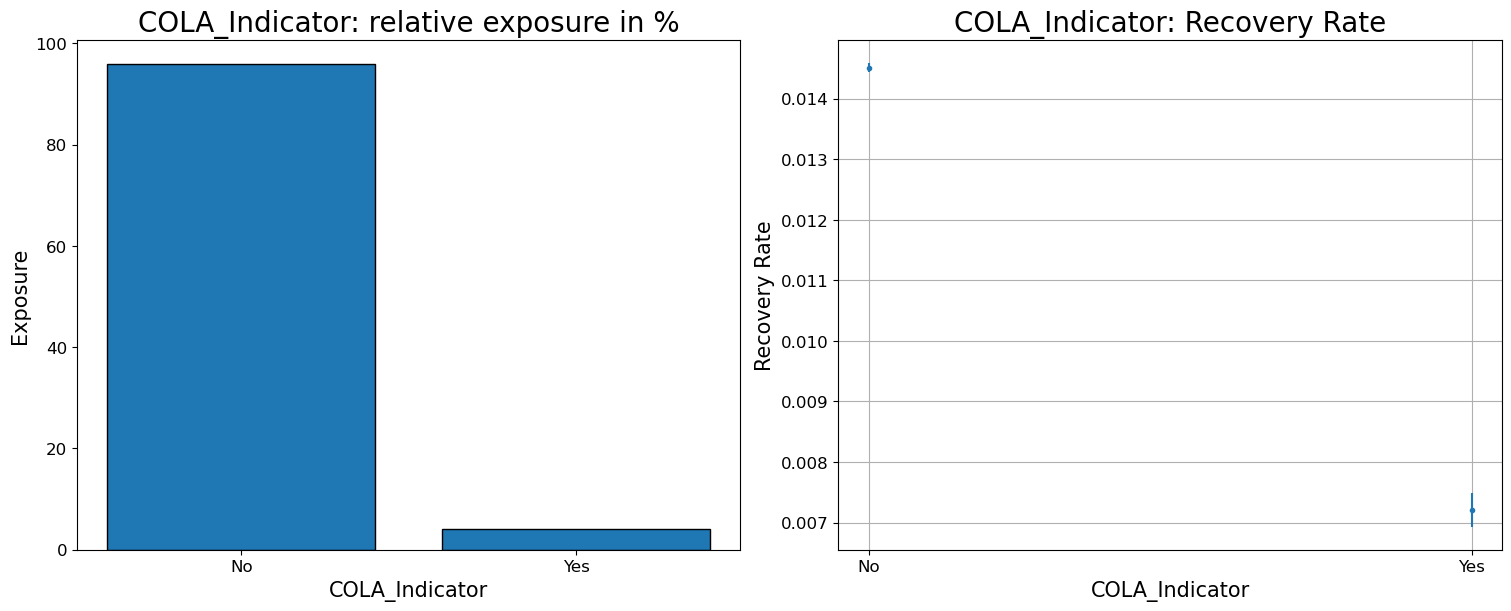

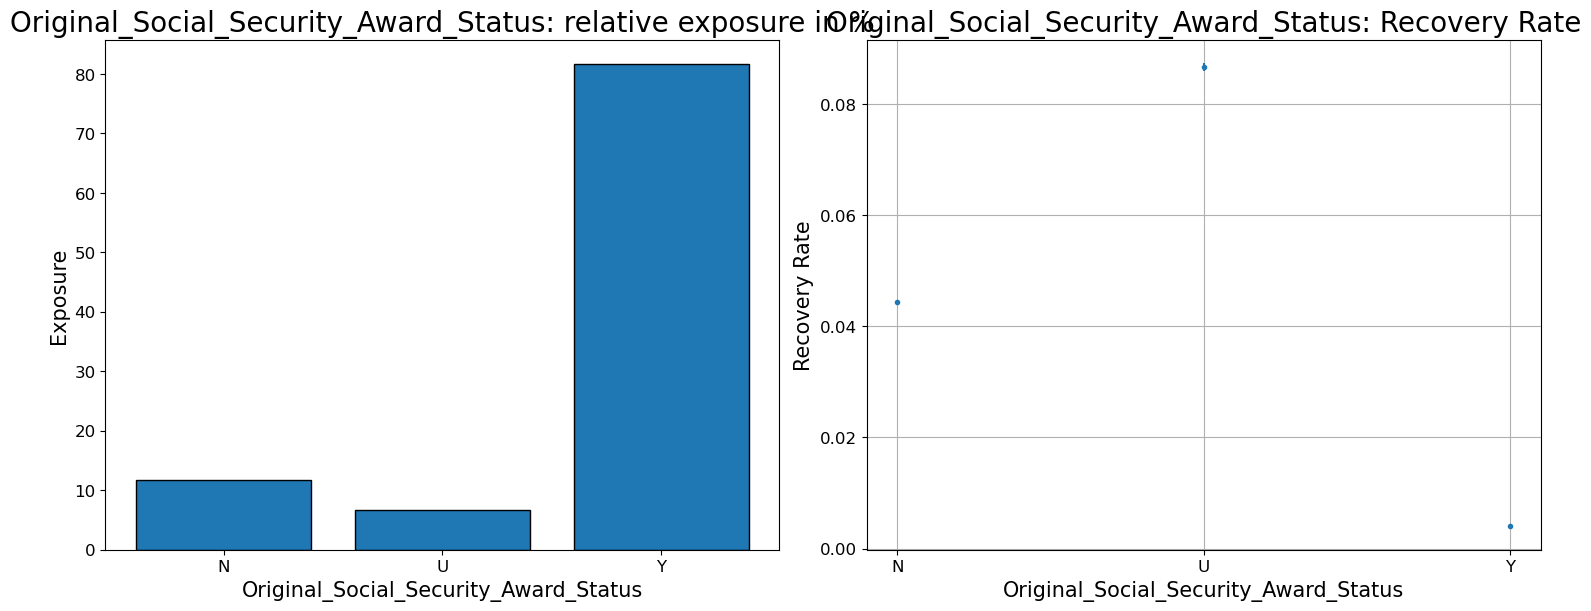

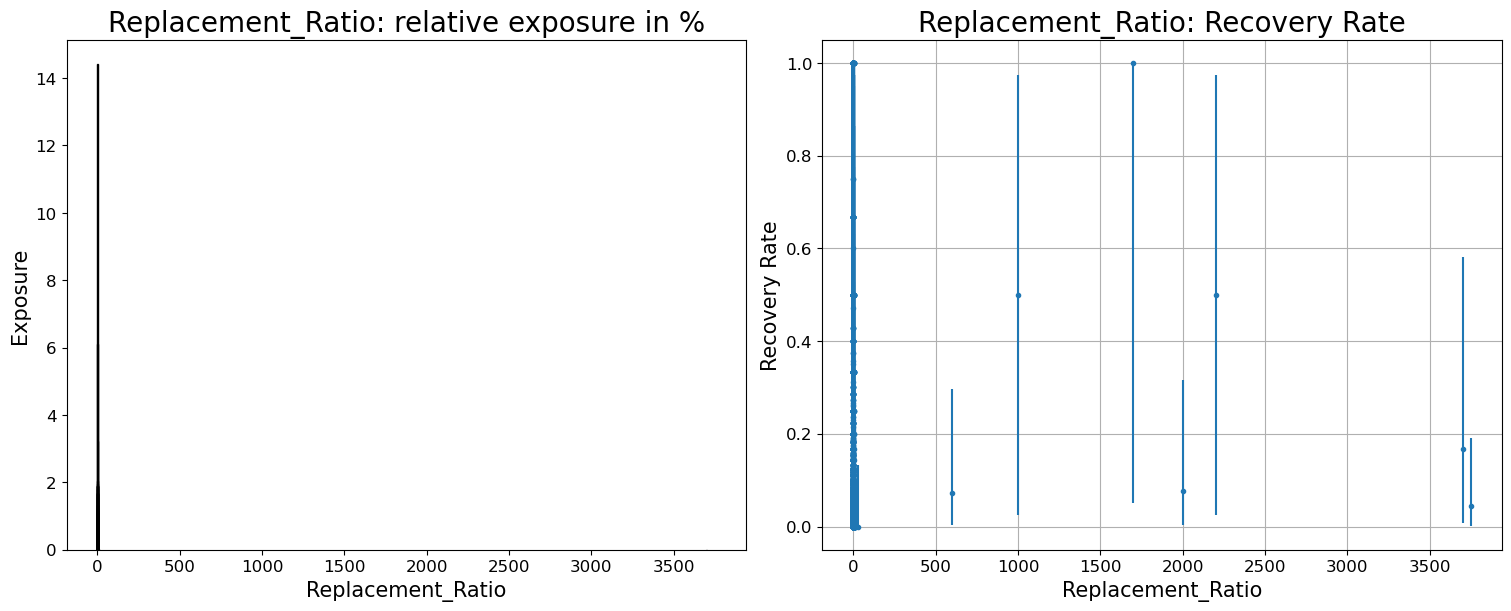

In [7]:
for fac in nm_fac:
    tt = marge_all[fac]
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(ncols=2, nrows=1, layout="constrained", 
                        figsize=(15, 6))
    ax[0].bar(tt[fac], np.round(tt["n"] / totex * 100, decimals=2),
            edgecolor="black")
    xticks = ax[0].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[0].tick_params(labelrotation=90)

    ax[0].set_xlabel(fac)
    ax[0].set_ylabel('Exposure')
    ax[0].set_title(fac + ": relative exposure in %")


    ax[1].errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.', linestyle='None')
    xticks = ax[1].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[1].tick_params(labelrotation=90)

    ax[1].grid(True)
    ax[1].set_xlabel(fac)
    ax[1].set_ylabel('Recovery Rate')
    ax[1].set_title(fac + ": Recovery Rate")

    plt.show()

## Special cases

This section handles some numeric variables which require special treatment, namely binning, since their conditional probabilities can not be calculated by simple aggregation. The number of bins is chosen manually for Replacement Ratio and as equal probability quantiles for the other cases.  

### Replacement Ratio

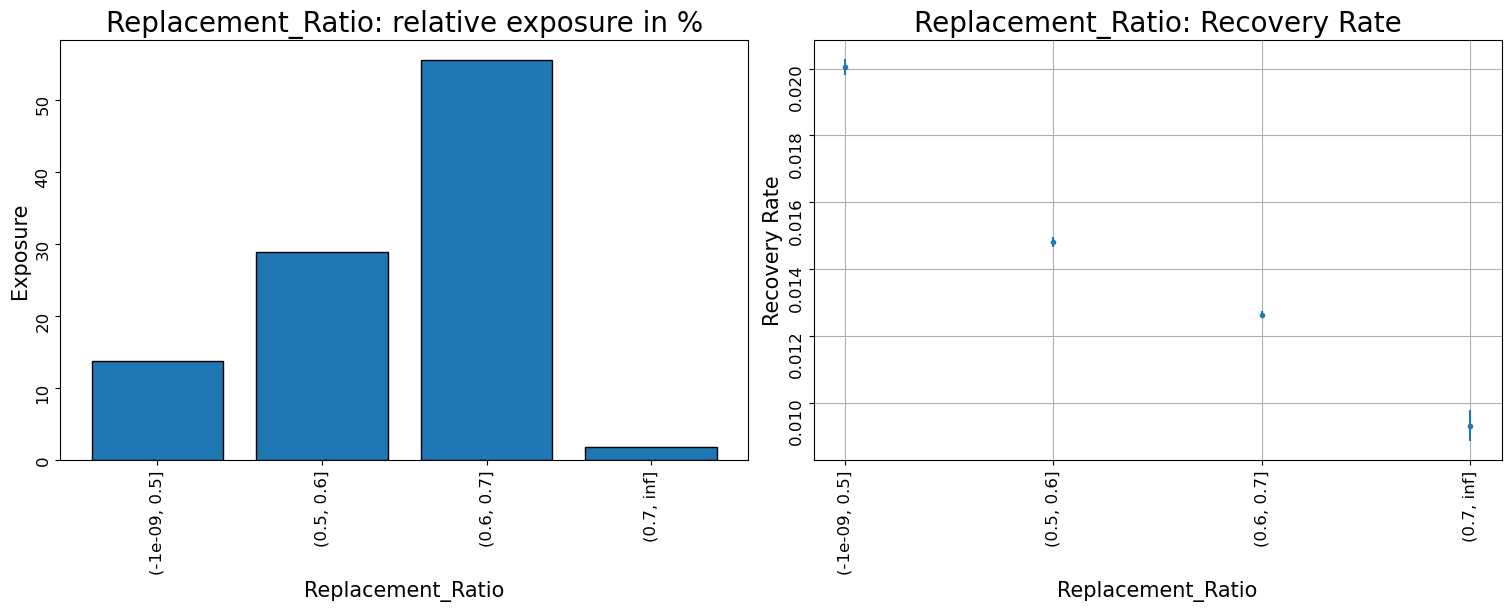

In [8]:
# cut recovery rate
fac = "Replacement_Ratio"
tmp =  pd.cut(gltd[fac], bins=[-1e-9, 0.5, 0.6, 0.7, np.inf]).astype(str)
tmptbl = pd.concat([gltd["Actual_Recoveries"], tmp], axis=1)
tt = rawrates([fac], tmptbl)

errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

fig, ax = plt.subplots(ncols=2, nrows=1, layout="constrained", 
                    figsize=(15, 6))
ax[0].bar(tt[fac], np.round(tt["n"] / totex * 100, decimals=2),
        edgecolor="black")
xticks = ax[0].get_xticklabels()
maxllen = max(len(label.get_text()) for label in xticks)
if maxllen > 9:
    ax[0].tick_params(labelrotation=90)

ax[0].set_xlabel(fac)
ax[0].set_ylabel('Exposure')
ax[0].set_title(fac + ": relative exposure in %")


ax[1].errorbar(tt[fac], tt["p"], yerr=errbars, 
            fmt='.', linestyle='None')
xticks = ax[1].get_xticklabels()
maxllen = max(len(label.get_text()) for label in xticks)
if maxllen > 9:
    ax[1].tick_params(labelrotation=90)

ax[1].grid(True)
ax[1].set_xlabel(fac)
ax[1].set_ylabel('Recovery Rate')
ax[1].set_title(fac + ": Recovery Rate")

plt.show()

### Monetary indicators

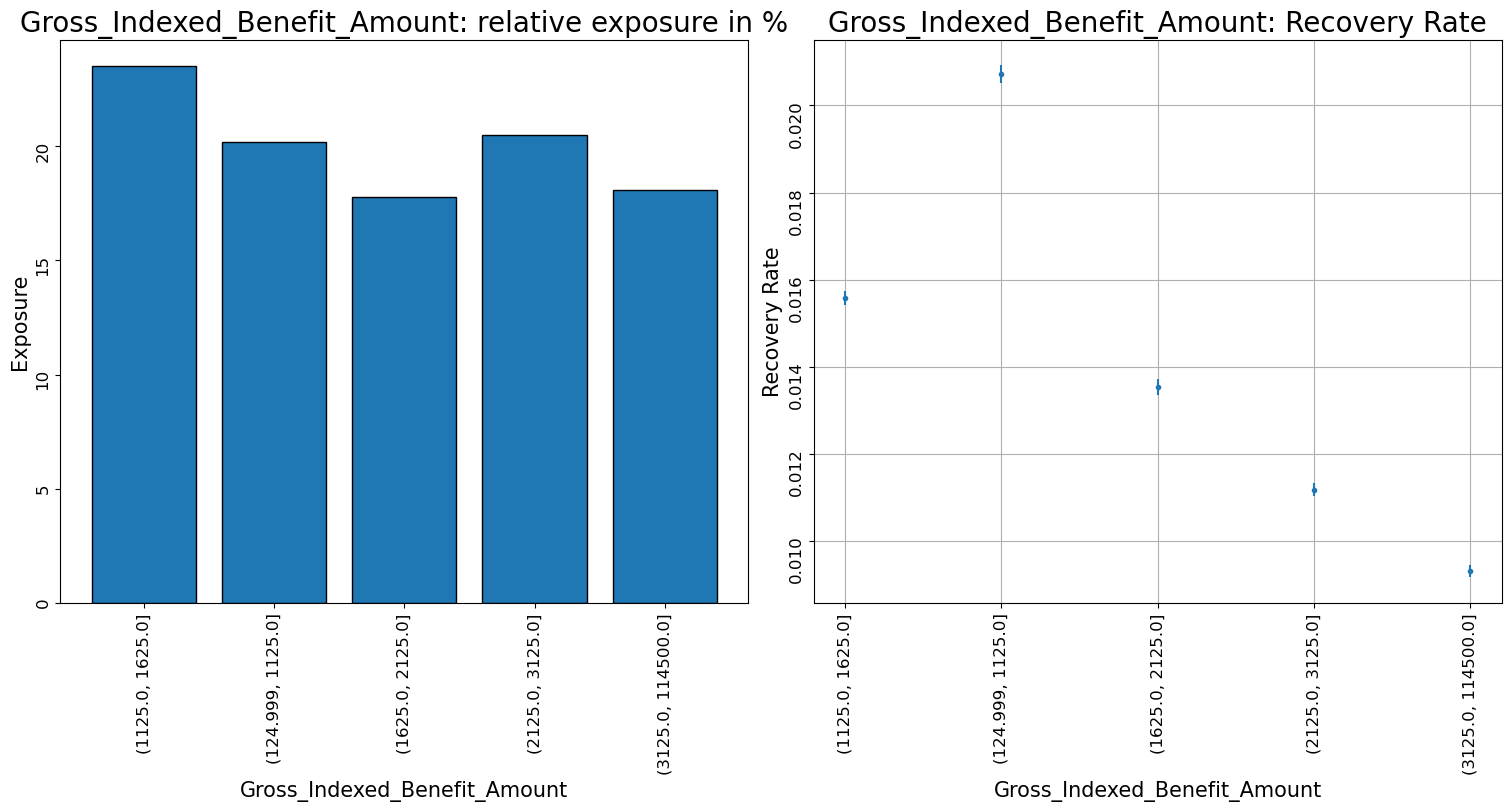

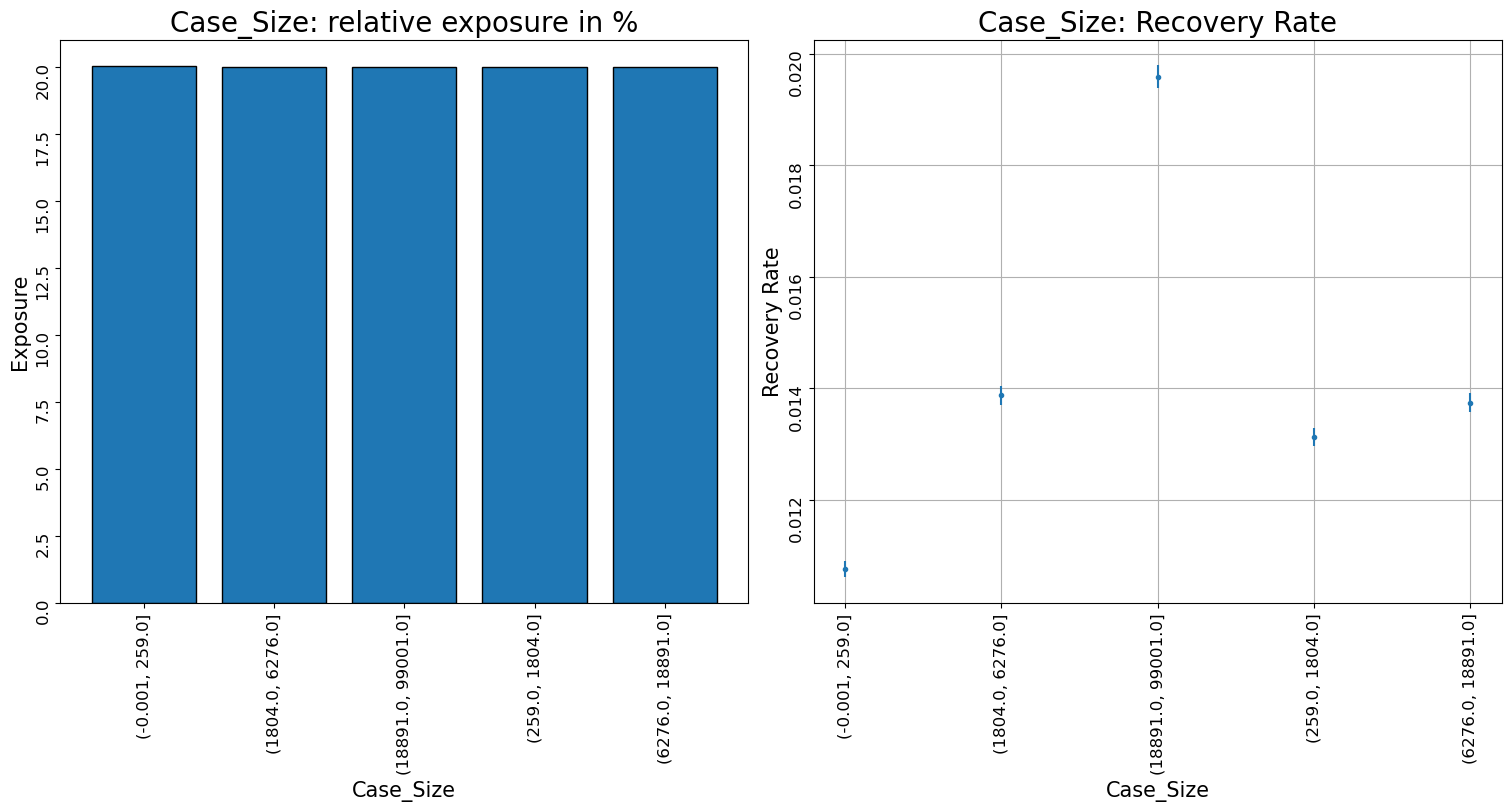

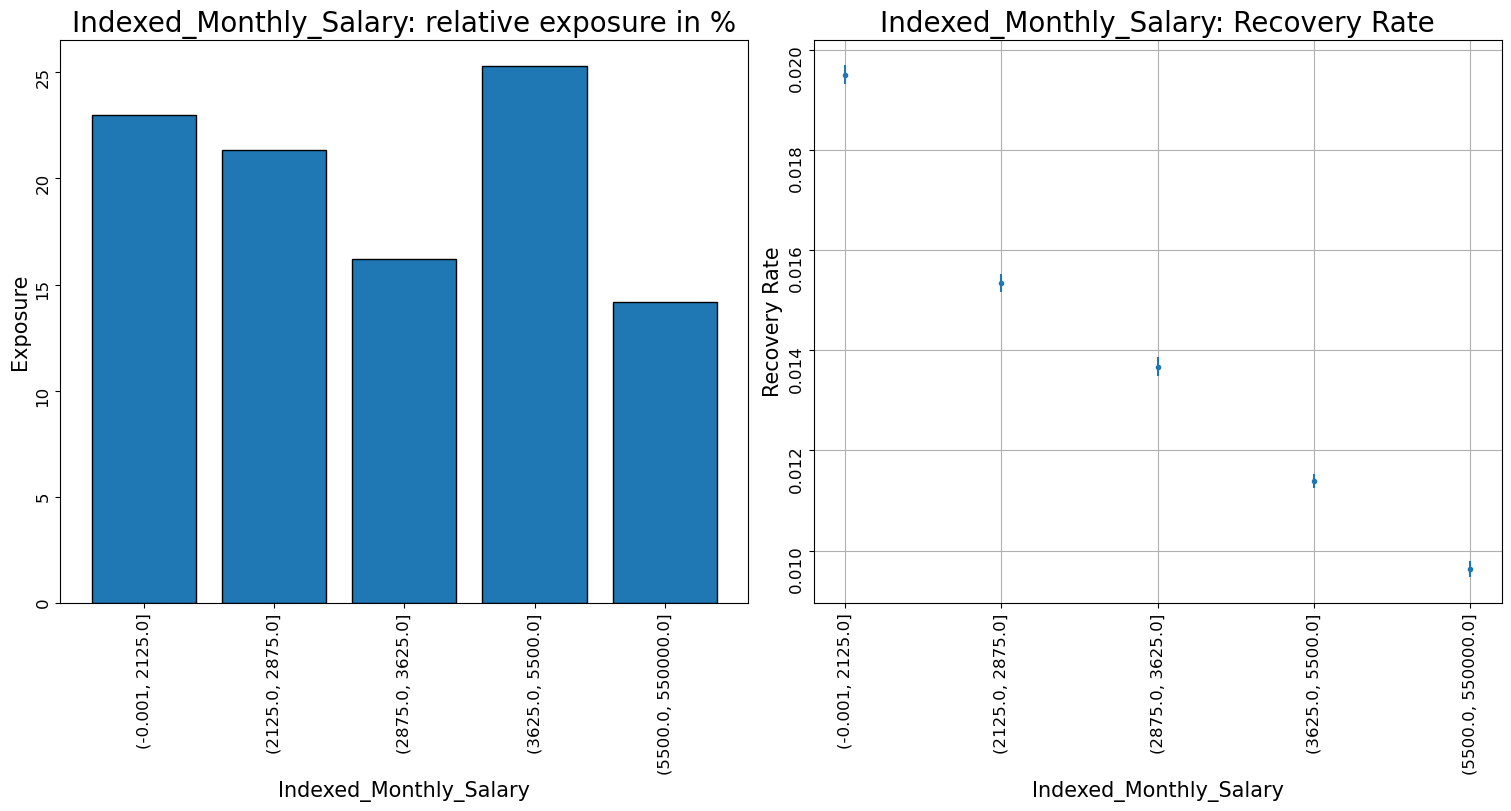

In [9]:
# bin monetary values
bincols = ["Gross_Indexed_Benefit_Amount", "Case_Size", "Indexed_Monthly_Salary"]
for fac in bincols:
    tmp = pd.qcut(gltd[fac], 5, retbins=True, duplicates="drop")[0]
    tmp =  tmp.astype(str)
    tmptbl = pd.concat([gltd["Actual_Recoveries"], tmp], axis=1)
    tt = rawrates([fac], tmptbl)

    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(ncols=2, nrows=1, layout="constrained", 
                        figsize=(15, 8))
    ax[0].bar(tt[fac], np.round(tt["n"] / totex * 100, decimals=2),
            edgecolor="black")
    xticks = ax[0].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[0].tick_params(labelrotation=90)

    ax[0].set_xlabel(fac)
    ax[0].set_ylabel('Exposure')
    ax[0].set_title(fac + ": relative exposure in %")


    ax[1].errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.', linestyle='None')
    xticks = ax[1].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[1].tick_params(labelrotation=90)

    ax[1].grid(True)
    ax[1].set_xlabel(fac)
    ax[1].set_ylabel('Recovery Rate')
    ax[1].set_title(fac + ": Recovery Rate")

    plt.show()  

### Zoom in

Some x-axis scaling to provide better visibility.

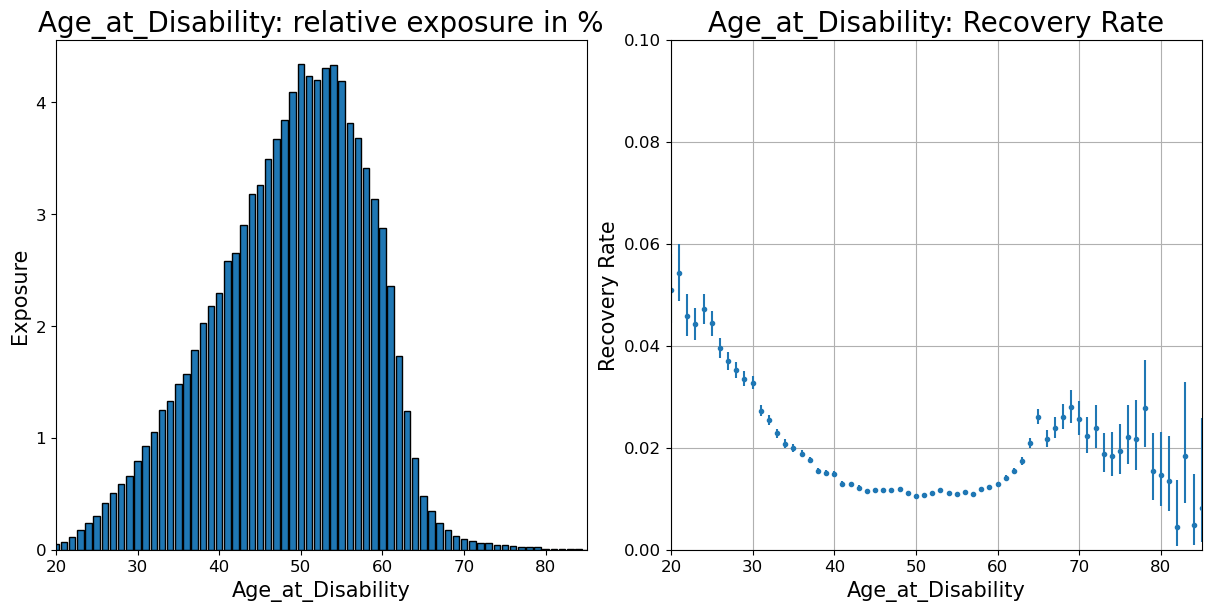

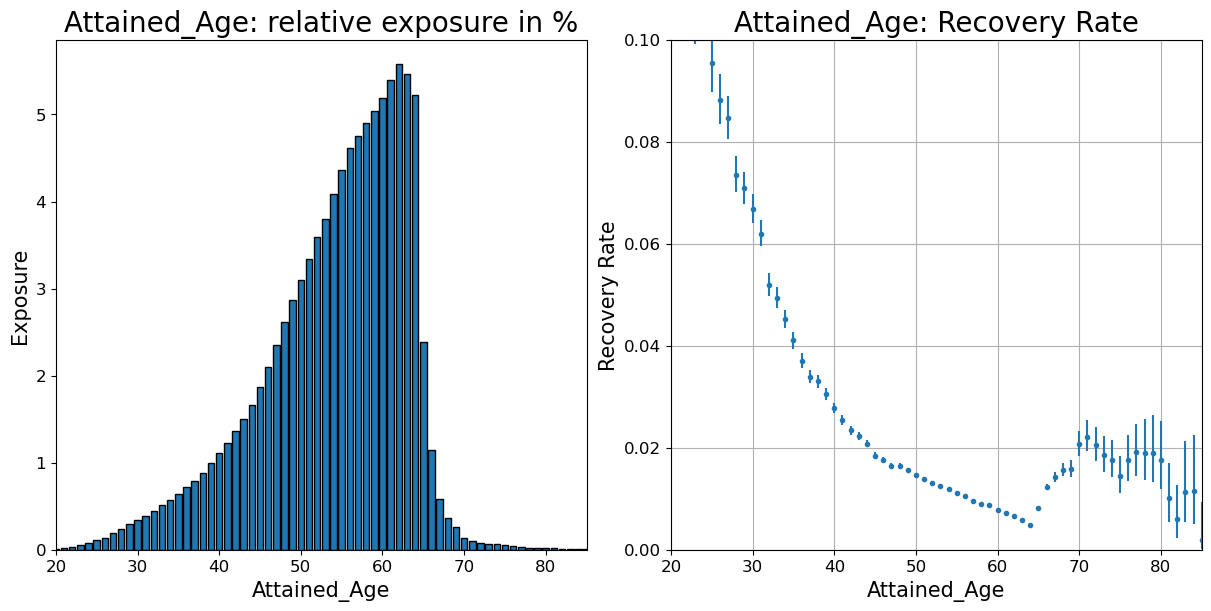

In [10]:
# cols to zoom in
zoomcols = ["Age_at_Disability", "Attained_Age"]
for fac in zoomcols:
# fac = "Calendar_Month"
    tt = marge_all[fac]
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(ncols=2, nrows=1, layout="constrained", 
                        figsize=(12, 6))
    ax[0].bar(tt[fac], np.round(tt["n"] / totex * 100, decimals=2),
            edgecolor="black")
    
    ax[0].set_xlim([20,85])

    xticks = ax[0].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[0].tick_params(labelrotation=90)

    ax[0].set_xlabel(fac)
    ax[0].set_ylabel('Exposure')
    ax[0].set_title(fac + ": relative exposure in %")


    ax[1].errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.', linestyle='None')
    xticks = ax[1].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[1].tick_params(labelrotation=90)

    ax[1].set_xlim([20,85])
    ax[1].set_ylim([0,0.1])

    ax[1].grid(True)
    ax[1].set_xlabel(fac)
    ax[1].set_ylabel('Recovery Rate')
    ax[1].set_title(fac + ": Recovery Rate")

    plt.show()

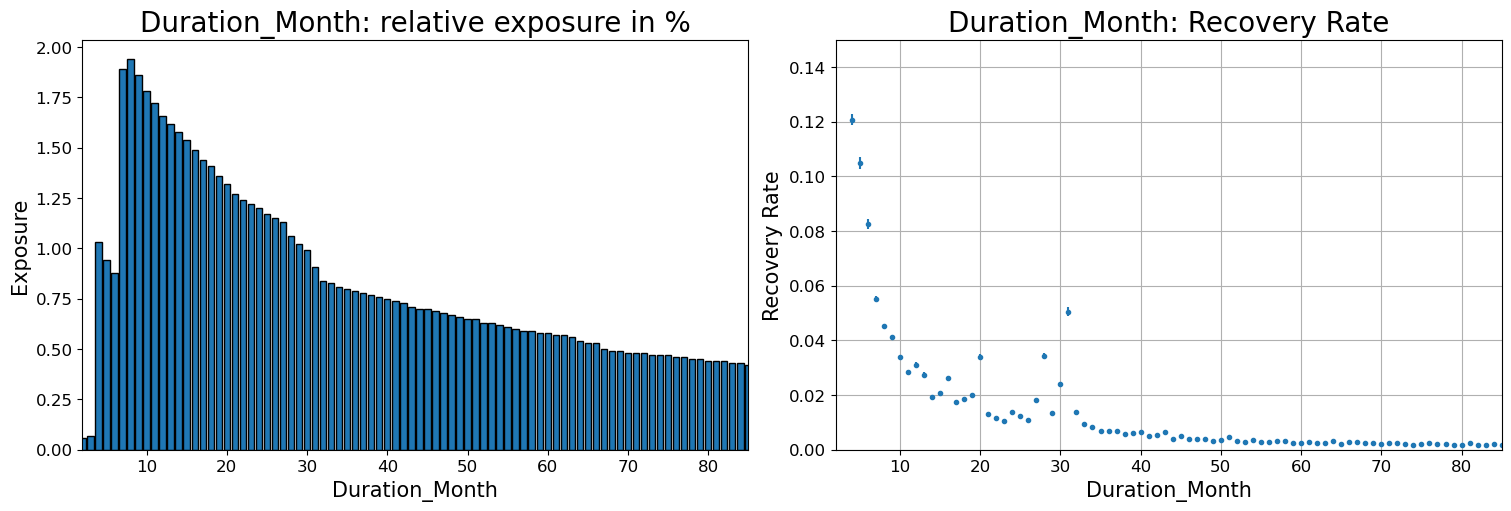

In [11]:
# cols to zoom in
zoomcols = ["Duration_Month"]
for fac in zoomcols:
    tt = marge_all[fac]
    errbars = np.abs((tt[['lo', 'hi']].subtract(tt['p'], axis=0)).values.T)

    fig, ax = plt.subplots(ncols=2, nrows=1, layout="constrained", 
                        figsize=(15, 5))
    ax[0].bar(tt[fac], np.round(tt["n"] / totex * 100, decimals=2),
            edgecolor="black")
    
    ax[0].set_xlim([2,85])

    xticks = ax[0].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[0].tick_params(labelrotation=90)

    ax[0].set_xlabel(fac)
    ax[0].set_ylabel('Exposure')
    ax[0].set_title(fac + ": relative exposure in %")


    ax[1].errorbar(tt[fac], tt["p"], yerr=errbars, 
                fmt='.', linestyle='None')
    xticks = ax[1].get_xticklabels()
    maxllen = max(len(label.get_text()) for label in xticks)
    if maxllen > 9:
        ax[1].tick_params(labelrotation=90)

    ax[1].grid(True)
    ax[1].set_xlim([2,85])
    ax[1].set_ylim([0,0.15])

    ax[1].set_xlabel(fac)
    ax[1].set_ylabel('Recovery Rate')
    ax[1].set_title(fac + ": Recovery Rate")

    plt.show()

# References

[Molnar](https://christophm.github.io/interpretable-ml-book/) https://christophm.github.io/interpretable-ml-book/